# Setup START
***
Skipped in slideshow mode, run manually before!

Ideally, the code would be placed with their corresponding content slides.\
Unfortunately, RISE slideshow mode will not execute SKIP slides and there is no other way to hide them.

In [1]:
%pip install --upgrade pip
# OpenAI Gym related:
%pip install cmake
%pip install atari_py 
'''OpenAI devs actually messed up an indentation
    in the video recorder class in 0.18.x.
    If you want to see videos, wait for a patch or
    use 0.17.x.
'''
%pip install gym[box2d]==0.17.3
%pip install pyvirtualdisplay
%pip install tqdm

# Gridworld related:
%pip install pymdptoolbox

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !apt-get install -y xvfb python-opengl > /dev/null 2>&1

### Setup: OpenAI Gym

In [3]:
from IPython import display
import numpy as np
import base64
import io
import gym
from tqdm import tqdm
from gym.wrappers import Monitor

if IN_COLAB:
    from pyvirtualdisplay import Display
    d = Display()
    d.start()

'''
Below is a solution to record and display videos for
OpenAI Gym environments.
Why the hassle?
    It works both in Jupyter Notebook and Google Colab!
(The author would like to note how painful it has been
developing this)
'''    

def display_video_from_monitor(monitor):
    '''
    Converts all videos in a monitor to HTML videos
    '''
    if len(monitor.videos) == 0:
        print("No videos to render!")
        return
    for f in monitor.videos:
        video = io.open(f[0], 'r+b').read()
        encoded = base64.b64encode(video)

        display.display(display.HTML(data="""
            <video alt="test" controls>
            <source src="data:video/mp4;base64,{0}" type="video/mp4" />
            </video>
            """.format(encoded.decode('ascii'))))
    return

def make_video(env, model, max_steps=None):
    mon = Monitor(env, "/data/videos/", force=True)
    state = mon.reset()
    i = 0
    while True:
        action = model(state)
        state, r, d, _ = mon.step(action)
        if d: break
        i+=1
        if max_steps is not None and i>=max_steps: break
    if mon.stats_recorder.done == False:    
        mon.stats_recorder.save_complete()
        mon.stats_recorder.done = True
    mon.reset()
    display_video_from_monitor(mon)
    return mon

### Setup: Grid World

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from mdptoolbox import mdp

class Gridworld():
    def __init__(self, actions, w=4, h=3, rho=1.0, step_reward=0.0, cell_rewards={},
               terminal_states=[], blocked_cells=[]):
        self.actions = actions
        self.w, self.h = w, h
        self.rho = rho
        self.step_reward = step_reward
        self.cell_rewards = cell_rewards
        self.terminal_states = {tuple(x) for x in terminal_states}
        self.blocked_cells = {tuple(x) for x in blocked_cells}

        self.grid = np.zeros((h,w))
        self.states = np.array([[i,j] for i in range(h) for j in range(w)])
        self.num_states = w*h
        self.num_actions = len(actions)
        self.p = np.zeros((self.num_actions, self.num_states, self.num_states), "float32")
        self.r = np.zeros((self.num_actions, self.num_states, self.num_states), "float32")
        self._fill_p()
        self._fill_r()

    def _fill_p(self):
        # computing transition matrix:
        for a in range(self.num_actions):
            for i in range(self.num_states):
                # simulate performing action a_ in state i
                # action a is performed with prob. rho,
                # with prob. 1-rho, any other action is chosen,
                # which results in prob. (1-rho)/(num_moves-1) for
                # a specific action a_ != a
                for a_ in range(self.num_actions):
                    rh, rw = self.simulate_move(self.actions[a_], self.states[i])
                    j_ = rh*self.w + rw
                    prob = self.rho if a == a_ else (1-self.rho)/(self.num_actions-1)
                    self.p[a, i, j_] += prob
                # due to numerical inaccuracies, we need to ensure that each row
                # adds up to exactly 1, not 0.999995, because the solvers
                # really dont seem to like that
                row_sum = self.p[a,i].sum()
                if row_sum != 1:
                    if not np.allclose(row_sum,1, rtol=1e-5, atol=1e-5):
                        raise ValueError(f"Probability error at action{a}, state {i}"
                                         f" with prob. {row_sum}")
                    self.p[a,i] /= row_sum
        return
        # make sure we can't ever leave terminal states
        for (i,j) in self.terminal_states:
            # transition probability from state (i,j) to any other state 
            # must be zero, but one for (i,j)
            index = i*self.w+j
            self.p[:,index,:] = 0
            self.p[:, index, index] = 1

    def _fill_r(self):
        # transitions always give step_reward
        self.r.fill(self.step_reward)
        
        # ending on a rewarded cell gives the corresponding reward
        for (i,j), reward in self.cell_rewards.items():
            self.r[:,:, i*self.w+j] += reward

        # terminal cells do not give ANY reward after having reached them
        for (i,j) in self.terminal_states:
            k = i*self.w+j
            self.r[:, k, :] = 0

        # should staying on cells still give the associated rewards?
        for i in range(self.num_actions):
            np.fill_diagonal(self.r[i],0)

    def simulate_move(self, move, state):
        if self._is_blocked(state): return state
        if self._is_terminal(state): 
            return state
        nm = np.clip(np.array(move)+np.array(state), 0, (self.h-1, self.w-1))
        if self._is_blocked(nm):
            return state
        return nm

    def solve(self, discount=0.99, verbose=False):
        '''
        Solves the underlying MDP using Policy Iteration
        Returns an object with the optimal policy. See
        `mdp.PolicyIteration` doc for details.
        '''
        vi = mdp.PolicyIteration(self.p, self.r, discount)
        if verbose:
            vi.setVerbose()
        vi.run()
        return vi
    
    def _is_blocked(self, cy, cx=None):
        # cx: position along grid width
        if cx is None:
            cy, cx = cy
        return (cy, cx) in self.blocked_cells

    def _is_terminal(self, cy, cx=None):
        if cx is None:
            cy, cx = cy
        return (cy, cx) in self.terminal_states
    
    def _plot_policy(self, policy):
        a_l = 0.6 # arrow length
        for (i,j), a in list(zip(self.states, policy)):
            if self._is_terminal(i,j) or self._is_blocked(i,j): continue
           
            dh, dw = self.actions[a]
            if dh == -1:
                y_off = 1 - (1-a_l)/2.
                x_off = 0.5
            elif dh == 0:
                y_off = 0.5
                if dw == -1:
                    x_off = 1 - (1-a_l)/2.0
                elif dw == 1:
                    x_off = (1-a_l)/2.0
                else: raise ValueError("Invalid action to plot!")
            elif dh == 1:
                y_off = (1-a_l)/2.0
                x_off = 0.5
            else: raise ValueError("Invalid action to plot")
            plt.arrow(j+x_off, i+y_off, dw*a_l, dh*a_l, width=0.1, 
                      head_width=0.4, head_length=0.6*0.35, fc="k", ec="k",
                      length_includes_head=True, linewidth=0, overhang=0.3, 
                      zorder=10)
        return

    def _plot_terminal_states(self):
        for (i,j) in self.terminal_states:
            c = plt.Circle((j+0.5,i+0.5), radius=0.3, fill=False, ec="black",
                          lw=3, zorder=6)
            plt.gca().add_patch(c)

    def _plot_blocked_cells(self):
        for (i,j) in self.blocked_cells:
            rect = patches.Rectangle((j,i),1,1, zorder=1, color=(1,219/255,147/255))
            plt.gca().add_patch(rect)        
            
    def _plot_rewards(self, resize_factor):
        if len(self.cell_rewards) == 0: return

        neg_cm = plt.get_cmap("Reds")
        pos_cm = plt.get_cmap("Greens")
        rmax = max(abs(x) for x in self.cell_rewards.values())
        rmin = -rmax
        for (i,j), r in self.cell_rewards.items():
            plt.text(j+0.05,i+0.95, f"{r:.1f}", zorder=10, weight="bold",
                    size=8*resize_factor)
            # to get the right color, we normalize to 0,255
            r_norm = 1.0 * (r-rmin)/(rmax-rmin)
            cm = pos_cm
            if r < 0:
                r_norm = 1.0 - r_norm
                cm = neg_cm
            col = cm(r_norm)
            rect = patches.Rectangle((j,i),1,1, zorder=1, color=col)
            plt.gca().add_patch(rect)   
            
    def plot(self, policy=None, height=None, width=None):
        if height is None and width is None:
            height = self.h
            width = self.w
        if height is None:
            height = self.h*(width/self.w)
        if width is None:
            width = self.w*(height/self.h)
        rf = height/self.h
        fig, ax = plt.subplots(figsize=(width, height))
        if policy is not None:
            self._plot_policy(policy)
        self._plot_terminal_states()
        self._plot_blocked_cells()
        self._plot_rewards(rf)
        ax.grid(zorder=10, lw=1)
        

        plt.xlim(0, self.w)
        plt.ylim(0, self.h)
        plt.tick_params(axis='both', which='both', bottom=False, top=False, 
                        labelbottom=False, right=False, left=False, labelleft=False)
        plt.xticks(range(self.w))
        plt.yticks(range(self.h))
        ax.invert_yaxis()
        plt.title("Grid world")
        plt.show()

# Setup END
***
(Click this cell, and do "Run all above")

# An introduction to Reinforcement Learning
***
Based on:
* **MIT 6.S091**: Introduction to Deep Reinforcement Learning, by Lex Fridman
* **UC Berkeley CS 287**: Advanced Robotics, by Pieter Abbeel

In [5]:
try:
    IN_COLAB
    print("Setup was run :)")
except:
    print("Don't forget to run the setup!")

Setup was run :)


# Agenda
***
1. What is Deep RL?
    * Deep Learning vs Deep Reinforcement Learning
2. Types of learning
    * Supervised vs unsupervised vs RL
    * RL in Humans, why are we so good?
3. Reinforcement Learning Framework
    * Agent, Action, State, Reward
4. Environments & Actions
    * Observability, Single VS Multi Agent, Deterministic/Stochastic, Static/Dynamic, Discrete/Continuous
5. RL in the real world
    * Two open problems:
        * Make better simulations
        * Make algorithms that generalize better from simulation to real world
6. Components of an RL agent
    * Policy, the behavior function, probability of taking $a_t$ when in state $s_t$
    * Value function, how good is each state/action in terms of expected future reward
        * $V_\pi(s)=E\left[\sum_{t=0}^{\infty}\gamma^t r_t\mid s_0 = s\right]$
    * Model, agent's representation of the environment
7. Meaning of Life: Maximize Reward
    * Future reward, discounted reward
        * Sparse reward problem
        * Credit assignment problem
8. Robot in a room/Gridworld:
    * Example to show the impact of reward structure and environment on the optimal policy
    * WE HAVE CODE NOW, WOOOOO
9. Types of RL (several ways to taxonomize exist!)
    * Model-based
        * learn a model of the world through interaction, then plan ahead using the model
    * Value-based (off policy)
        * Learn the values for states or states/actions
            * Constantly update how good it is to take action $a$ in state $s$
            * Act by choosing the best action in state. Exploration is needed!
    * Policy-based
        * Learning the right behavior function that maps state to action
        * Act by sampling policy, exploration already included
10. Taxonomy by OpenAI
    * Is this needed?
    
TODO:
DQN oder A2C
+ Daran gebundene Challenge

# What is Deep Reinforcement Learning?
***
Last lecture we heard about **Deep Learning**:
* Learn from examples, supervised
* Find patterns, representations

**Reinforcement Learning** is about:
* Solving sequential decision making problems
    * Comprehend the world and *act* based on that
* How? Through trial and error in a world that provides rewards

**Deep RL** is RL + Neural networks

# Types of learning
***
* Supervised, Semi-supervised
* Unsupervised
* Reinforcement learning

In each case of machine learning, the loss function **supervises** the learning
* Someone has to say what's good and what's bad!

It's more about the amount of human effort involved in training.
* Supervised learning: Teach by example
    * Learning patterns from data
* Reinforcement learning: Teach by experience
    * Learning from a world by exploration

# Reinforcement learning in humans
***
Humans appear to learn from very few examples of trial and error.
* How, is still an open question

There are several possible answers to why humans might learn so fast
* Data & Hardware: 230 million years of trial and error
* Imitation learning: Observation of other humans
* Algorithms: Better than backpropagation and gradient descent

# Reinforcement learning framework
***
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/da/Markov_diagram_v2.svg/640px-Markov_diagram_v2.svg.png" style="float: right;">

At each step, the **agent**:
* Executes an **action**
* Observes a new **state**
* Receives a **reward**

# Environments and actions
***
* Fully Observable (Chess) vs Partially Observable (Poker)
* Single Agent (Atari) vs Multi Agent (Deep Traffic)
* Deterministic (CartPole) vs Stochastic (Deep Traffic)
* Static (Chess) vs Dynamic (Deep Traffic)
* Discrete (Chess) vs Continuous (CartPole)

# The challenge for real world RL applications
***
The world an agent might learn from is a model designed by us
* Agents live in a (partial) simulation of our world

To apply RL agents to the real world, they need to *transfer* their experience
* Two options:
    * Improve the simulations
    * Improve algorithms to better generalize from simulation to real world

# Components of an RL agent
***
**Policy $\pi$**, an agent's behavior function:\
$\pi(s,a)=P\left(a_t=a\mid s_t=s\right)$

**Value function $Q$**: How good is each state and/or action\
$\displaystyle Q^\pi(s,a)=E\left[R\mid s,a,\pi\right]$

**Reward $R_a(s,s')$**:\
The immediate reward after transition from $s$ to $s'$ with action $a$

**Model**: The agent's representation of the environment
<br>
<br>
<center>$s_0,a_0,r_1,s_1,a_1,r_2,\dots,s_{n-1},a_{n-1},r_n$</center>


# Meaning of life: Maximize Reward
***
The purpose of an RL agent is to maximize the future reward\
$R_t=r_t+r_{t+1}+\cdots+r_n$

Rewards are discounted by factor $\gamma$:\
$R_t=r_t+\gamma r_{t+1}+\gamma^2 r_{t+2}+\cdots+\gamma^{n-t}r_n$

Why discounted?
* A math trick to prove certain convergence properties
* Also accounts for increasing uncertainty of far out rewards

A good strategy would be to always choose the action that gives the highest future reward

# Grid World or *Robot in a room*
***
Imagine a robot in a room. It may move and find:
* Positive and negative rewards, as shown by value and color
* Terminal states, indicated by a circle
* Walls/Blocks, appearing yellow(ish)

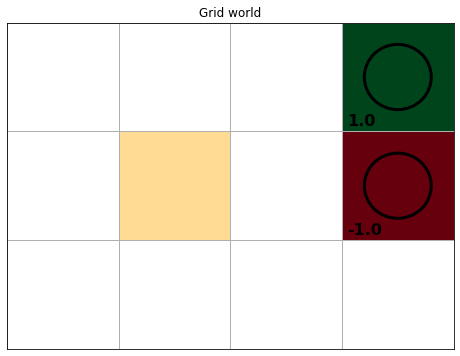

In [71]:
rewards = {(0,3):1,(1,3):-1}
terminal_states = rewards.keys()
blocks = [(1,1)]
grid_world = Gridworld([],w=4,h=3, cell_rewards=rewards, 
                       terminal_states=terminal_states,
                       blocked_cells=blocks)
grid_world.plot(width=8)

# Deterministic movement
***
We'll allow our robot to move UP, DOWN, LEFT and RIGHT, but each move costs
* Denoted by `step_reward=-0.04`

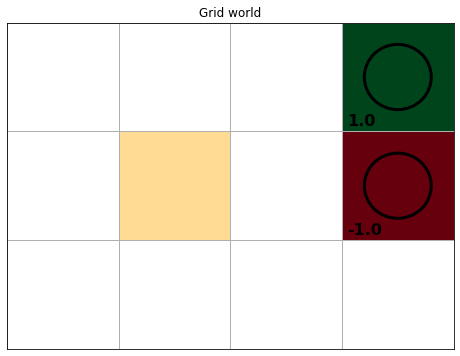

In [72]:
actions = np.array([
    [-1,0], # UP
    [1,0], # DOWN 
    [0,-1], # Left
    [0,1], # Right
])

rewards = {(0,3):1,
           (1,3):-1}
terminal_states = list(rewards.keys())
blocks = [(1,1)]

grid_world = Gridworld(actions,w=4,h=3, step_reward=-0.04,
                       cell_rewards=rewards, 
                       terminal_states=terminal_states,
                       blocked_cells=blocks)

grid_world.plot(width=8)

# Markov decision process (MDP)
***
What would be the optimal move on each cell to achieve the highest possible reward?
* The theory behind Markov decision processes allows us to solve this!
    * This is where the discount factor $\gamma$ is needed

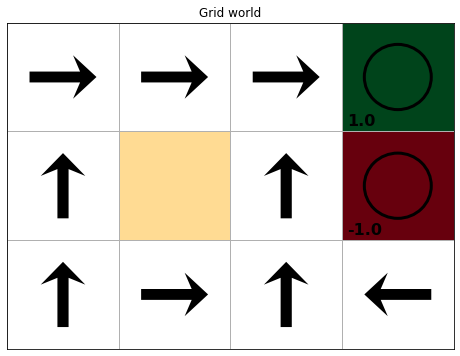

In [73]:
result = grid_world.solve(discount=0.99)
grid_world.plot(policy=result.policy, width=8)

**Policy**: Shortest path to $+1$ reward

# Optimal policy for positive `step_reward`
***
Everything else being equal, how would a positive `step_reward` influence the agent's optimal behavior?

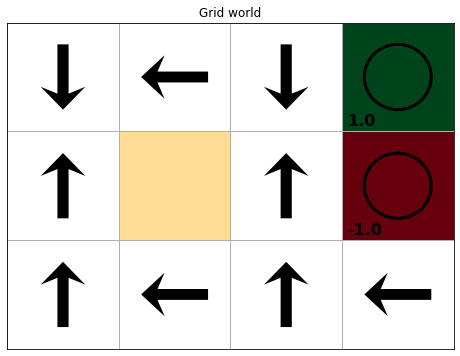

In [74]:
grid_world = Gridworld(actions,w=4,h=3, step_reward=0.04,
                       cell_rewards=rewards, 
                       terminal_states=terminal_states,
                       blocked_cells=blocks)
result = grid_world.solve(discount=0.99)
grid_world.plot(policy=result.policy, width=8)

**Policy**: Never terminate!

# Adding uncertainty
***
So far, each action chosen by the agent resulted in exactly the anticipated outcome
* It's a *deterministic* world our robot lives in

However, some systems are stochastic by nature, or too complex to model deterministically
* How would uncertainty impact the optimal policy in our grid world?
* We let $\rho\in (0,1]$ denote the probability of executing the intended action $a$
    * But with prob. $1-\rho$ any other action is executed

Here is the deterministic result ($\rho=1$):

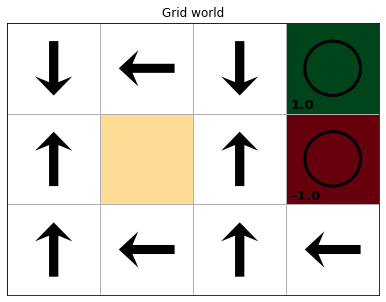

In [78]:
grid_world = Gridworld(actions,w=4,h=3, step_reward=0.04,
                       cell_rewards=rewards, 
                       terminal_states=terminal_states,
                       blocked_cells=blocks)
result = grid_world.solve(discount=0.99)
grid_world.plot(policy=result.policy, height=5)

What happens for $\rho=0.7$ ?

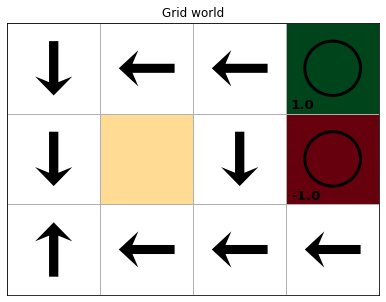

In [92]:
grid_world = Gridworld(actions,w=4,h=3, step_reward=0.04,
                       rho=0.7, cell_rewards=rewards, 
                       terminal_states=terminal_states,
                       blocked_cells=blocks)
result = grid_world.solve(discount=0.99)
grid_world.plot(policy=result.policy, height=5)

# Lessons learned from Grid World
***
1. Environment model has big impact on optimal policy
2. Reward structure has big impact on optimal policy

In [100]:
import IPython
IPython.display.HTML('''
<iframe width="800" height="510" src="https://www.youtube.com/embed/tlOIHko8ySg" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>
''')

# Placeholder
***

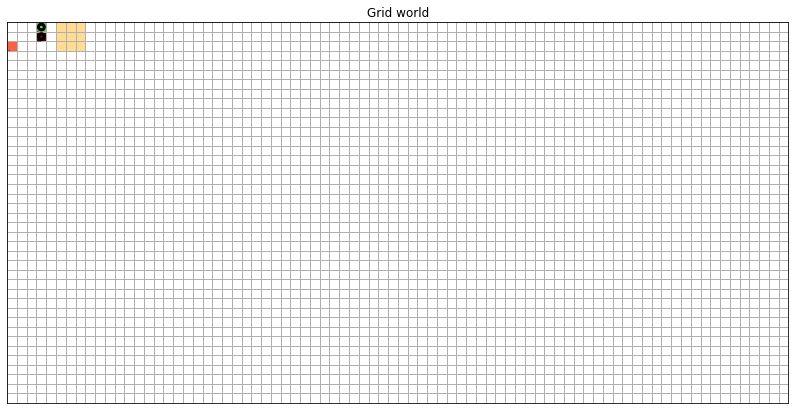

In [53]:
w=80; h=40; rho=1.0; step_reward=-0.04;

actions = np.array([
    [-1,0], # UP
    #[1,0], # DOWN 
    [0,-1], # Left
    [0,1], # Right
])
cell_rewards={
    (0,3): 1,
    (1,3): -100,
    #(1,6): 1,
    (2,0): -4,
}
terminal_states=[
    [0,3],
    [1,3],
]
blocked=[
    [0,5],
    [1,5],
    [2,5],
    [0,6],
    [1,6],
    [2,6],
    [0,7],
    [1,7],
    [2,7],
]

gw  = Gridworld(w=w, h=h, rho=rho, step_reward=step_reward,
                cell_rewards=cell_rewards, actions=actions,
                terminal_states=terminal_states, blocked_cells=blocked)
gw.plot(height=7)

In [55]:
#vi = mdp.ValueIteration(gw.p, gw.r, 0.9, max_iter=1e5)
vi = mdp.PolicyIteration(gw.p, gw.r, 0.99, max_iter=50, eval_type=0)
vi.setVerbose()
vi.run()
#print(vi.policy)
gw.plot(policy=vi.policy, height=10)
#vi.V

  Iteration		Number of different actions
    1		  161
    2		  190
    3		  80
    4		  71
    5		  64
    6		  98
    7		  107
    8		  113
    9		  128
    10		  142
    11		  143
    12		  176
    13		  190
    14		  204
    15		  226
    16		  224
    17		  248
    18		  263
    19		  248
    20		  263


KeyboardInterrupt: 

# OpenAI Gym
***

In [ ]:
import numpy as np
from tensorflow.keras.layers import (
    Dense, Input, Dropout    
)
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.losses import Huber
from tensorflow import keras

import gym


def episode(env, model, max_steps=None):
    states = []
    action_probs = []
    est_rewards = []
    rewards = []

    state = env.reset()
    i = 0
    while i < (j := max_steps if max_steps is not None else np.inf):
        state = tf.convert_to_tensor(state)
        state = tf.expand_dims(state, 0)
        states.append(state)

        a_p, e_w = model(state)
        action = np.random.choice(env.action_space.n, p=np.squeeze(a_p))
        state, reward, done, info = env.step(action)

        action_probs.append(a_p[0, action])
        est_rewards.append(e_w[0,0])
        rewards.append(reward)

        i += 1
        if done:
            break
    env.close()
    return states, rewards, action_probs, est_rewards

def sample_action(model, state):
    # state is a cpu np array
    state = tf.convert_to_tensor(state)
    state = tf.expand_dims(state, 0)
    a_p, e_w = model(state)
    action = np.random.choice(env.action_space.n, p=np.squeeze(a_p))
    return action   

In [ ]:
env = gym.make('LunarLander-v2')
env.action_space

In [ ]:
env = gym.make('LunarLander-v2').unwrapped
#env = gym.make('MountainCar-v0').unwrapped

critic_loss_func = keras.losses.Huber()

input_layer = Input(env.observation_space.shape)
l = Dense(128, "relu")(input_layer)
l = Dense(64, "relu")(l)
actor = Dense(env.action_space.n, "softmax", name="actor")(l)
critic = Dense(1, name="critic")(l)
model = Model(input_layer, [actor, critic])

model.summary()
opt = keras.optimizers.Adam(lr=0.01)

In [ ]:
epochs = 10000
gamma = 0.95
train_max_steps = 300
validation_every = 50
validation_episodes = 5
validation_max_steps = 200

reward_history = []

for epoch in range(epochs):

    with tf.GradientTape() as tape:
        states, rewards, action_probs, est_rewards = episode(env, model, train_max_steps)
        reward_history.append(sum(rewards))

        returns = []
        discounted_sum = 0
        for r in rewards[::-1]:
            discounted_sum = r + gamma * discounted_sum
            returns.insert(0, discounted_sum)
        returns = np.array(returns)
        returns = (returns - returns.mean()) / returns.std()

        critic_labels = tf.convert_to_tensor(returns, "float32")

        # critic_loss = critic_loss_func(est_rewards, critic_labels)
        cl = []
        for f,g in zip(est_rewards, critic_labels):
            cl.append(critic_loss_func(tf.expand_dims(f,0), tf.expand_dims(g,0)))
        critic_loss = sum(cl)

        al = -tf.math.log(action_probs) * (critic_labels - est_rewards)
        actor_loss = sum(al)
        loss = actor_loss + critic_loss

        gradients = tape.gradient(loss, model.trainable_weights)
        opt.apply_gradients(zip(gradients, model.trainable_weights))

    if epoch % validation_every == 0:
        val_rewards = []
        for val_e in range(validation_episodes):
            states, rewards, action_probs, est_rewards = episode(env, model, validation_max_steps)
            val_rewards.append(sum(rewards))
        val_rewards = np.array(val_rewards)
        print(f"Epoch {epoch}/{epochs}",epoch, np.mean(reward_history),  val_rewards.min(), val_rewards.max(), val_rewards.mean())
        reward_history.clear()
        make_video(env, lambda state: sample_action(model, state), max_steps=1000)
        pass

In [ ]:
make_video(env, lambda state: sample_action(model, state))


In [ ]:
def make_video(env, model, max_steps=None):
    mon = Monitor(env, "/data/videos/", force=True)
    state = mon.reset()
    i = 0
    while True:
        action = model(state)
        state, r, d, _ = mon.step(action)
        if d: break
        i+=1
        if max_steps is not None and i>=max_steps: break
    if mon.stats_recorder.done == False:
        mon.stats_recorder.save_complete()
        mon.stats_recorder.done = True
    mon.reset()
    display_video_from_monitor(mon)
    return mon

In [ ]:
make_video(env, lambda state: sample_action(model, state), max_steps=1000)

In [ ]:
env.close()

In [ ]:
mon = Monitor(env)
mon.reset()